In [1]:
import nfl_data_py as nfl
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
pd.set_option("display.max_columns", None)
import sklearn
from analysis import PositionReport

import warnings
warnings.filterwarnings("ignore")

In [2]:
# List of functions used in the notebook

def execute_statement(sql: str):
    with psycopg2.connect(host="localhost", database="thefantasybot", user="tbakely") as conn:
         df = pd.read_sql(sql, conn)
         return df

def get_corr_heatmap(df: pd.DataFrame):
    exclude_words = ["season", "week"]
    numerical_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']\
                      and not any(word in col.lower() for word in exclude_words)]
    correlation_matrix = df[numerical_cols].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5, mask=mask)
    plt.show()

In [227]:
weekly_sql = """
select
	wd.player_id,
	wd.player_name,
	position,
	recent_team,
	wd.season,
	wd.week,
	carries,
	rushing_yards,
	rushing_tds,
	rushing_fumbles,
	rushing_fumbles_lost,
	rushing_first_downs,
	rushing_epa,
	efficiency,
	percent_attempts_gte_eight_defenders,
	avg_time_to_los,
	rush_yards_over_expected,
	avg_rush_yards,
	rush_yards_over_expected_per_att,
	rush_pct_over_expected,
	wd.receptions,
	wd.targets,
	receiving_yards,
	receiving_tds,
	receiving_fumbles,
	receiving_fumbles_lost,
	receiving_air_yards,
	receiving_yards_after_catch,
	receiving_first_downs,
	receiving_epa,
	racr,
	target_share,
	air_yards_share,
	wopr,
	offense_snaps,
	offense_pct,
    redzone.redzone,
	(carries + wd.targets) as total_usage,
    wd.fantasy_points,
    wd.fantasy_points_ppr,
	roof,
	surface,
	weather_hazards,
	temp,
	humidity,
	wind_speed
from archive_data.weekly_data wd
left join archive_data.offense_snap_counts os
on wd.player_id = os.id
and wd.season = os.season
and wd.week = os.week
left join archive_data.ngs_rushing_data ngsr
on wd.player_id = ngsr.player_gsis_id
and wd.season = ngsr.season
and wd.week = ngsr.week
left join archive_data.ngs_receiving_data ngsp
on wd.player_id = ngsp.player_gsis_id
and wd.season = ngsp.season
and wd.week = ngsp.week
left join (select distinct rusher_player_id, game_id, season, week from archive_data.full_pbp) game_id
on wd.player_id = game_id.rusher_player_id
and wd.season = game_id.season
and wd.week = game_id.week
left join archive_data.game_data
on game_data.game_id = game_id.game_id
left join archive_data.redzone_snaps redzone
on wd.player_id = redzone.player_id
and wd.season = redzone.season
and wd.week = redzone.week
where position in ('WR', 'RB', 'TE')
and wd.season between 2016 and 2022;
"""

weekly_wr = """
select 
wr.player_name, 
wr.position, 
wr.season,
wr.week,
offense_snaps,
offense_pct,
target_share,
targets,
receiving_epa,
redzone
from current_season_data.weekly_wr wr
left join current_season_data.redzone_snaps rz
on wr.player_id = rz.player_id
and wr.season = rz.season
and wr.week = rz.week
"""

weekly_rb = """
select
rb.player_name,
rb.position,
rb.season,
rb.week,
offense_snaps,
offense_pct,
total_usage,
rushing_epa,
rush_yards_over_expected_per_att,
rush_pct_over_expected,
target_share,
receiving_epa,
redzone
from current_season_data.weekly_rb rb
left join current_season_data.redzone_snaps rz
on rb.player_id = rz.player_id
and rb.season = rz.season
and rb.week = rz.week
"""

weekly_te = """
select 
te.player_name, 
te.position, 
te.season,
te.week,
offense_snaps,
offense_pct,
target_share,
targets,
receiving_epa,
redzone
from current_season_data.weekly_te te
left join current_season_data.redzone_snaps rz
on te.player_id = rz.player_id
and te.season = rz.season
and te.week = rz.week
"""


In [161]:
weekly = execute_statement(weekly_wr)
weekly_rb = execute_statement(weekly_rb)

In [1]:
from analysis import PositionReport as PR

In [2]:
rb_report = PR("RB")
wr_report = PR("WR")
te_report = PR("TE")

In [4]:
rb_report.get_report_by_week(7)

,player_name,position,season,week,score
580,A.Kamara,RB,2023,7,113.886772
558,D.Foreman,RB,2023,7,87.840555
88,J.Taylor,RB,2023,7,43.442931
520,J.Williams,RB,2023,7,34.466267
102,S.Barkley,RB,2023,7,34.327871
...,...,...,...,...,...
535,T.Chandler,RB,2023,7,3.797860
438,T.Bigsby,RB,2023,7,3.726004
608,J.Wilson,RB,2023,7,3.642554
55,T.Homer,RB,2023,7,3.616901


In [351]:
rb_pos = PositionReport("RB")
rb_pos.get_report_by_week(5).head(24)


,player_name,position,season,week,score
543,Z.Moss,RB,2023,5,86.971579
182,T.Etienne,RB,2023,5,54.935634
291,B.Hall,RB,2023,5,54.265463
322,D.Montgomery,RB,2023,5,53.925102
269,D.Achane,RB,2023,5,36.461634
208,J.Jacobs,RB,2023,5,35.948224
582,A.Kamara,RB,2023,5,31.173791
26,J.Mixon,RB,2023,5,30.779226
42,R.Mostert,RB,2023,5,29.985235
589,C.McCaffrey,RB,2023,5,26.513171


In [339]:
compare_reports("WR", 1, 8).head(24)

,player_name,position,season,score
71,J.Chase,WR,2023,77.569239
34,D.Adams,WR,2023,71.685203
9,A.Thielen,WR,2023,70.831829
95,K.Allen,WR,2023,67.629951
160,T.Hill,WR,2023,66.466448
23,C.Kupp,WR,2023,66.195263
0,A.Brown,WR,2023,64.168832
76,J.Jefferson,WR,2023,64.046484
64,G.Wilson,WR,2023,64.013162
150,S.Diggs,WR,2023,63.673513


In [342]:
get_report_by_week("RB", 6).head(24)

,player_name,position,season,week,score
41,R.Mostert,RB,2023,6,90.302329
326,K.Williams,RB,2023,6,63.229287
103,S.Barkley,RB,2023,6,52.122340
199,I.Pacheco,RB,2023,6,48.721759
207,J.Jacobs,RB,2023,6,48.187265
181,T.Etienne,RB,2023,6,44.131697
316,K.Walker,RB,2023,6,42.206925
588,C.McCaffrey,RB,2023,6,40.002500
70,T.Pollard,RB,2023,6,37.383640
455,D.Singletary,RB,2023,6,35.285545


In [286]:
def get_corr_heatmap(df: pd.DataFrame):
    exclude_words = ["season", "week"]
    numerical_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']\
                      and not any(word in col.lower() for word in exclude_words)]
    correlation_matrix = df[numerical_cols].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5, mask=mask)
    plt.show()

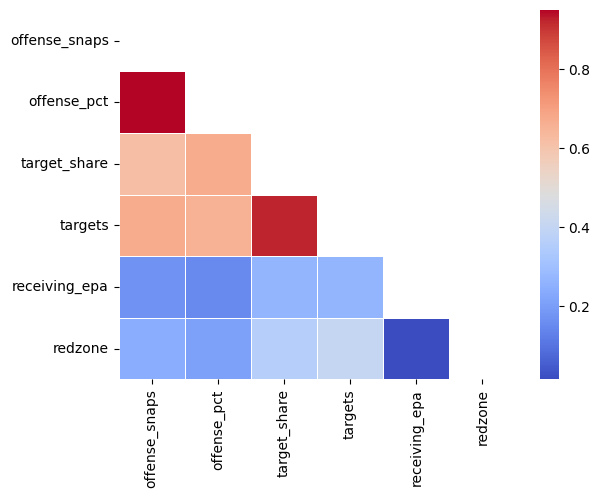

In [290]:
get_corr_heatmap(wr_df)

In [274]:
numerical_cols

['season',
 'week',
 'offense_snaps',
 'offense_pct',
 'target_share',
 'targets',
 'receiving_epa',
 'redzone']

In [164]:
weekly_rb["score"] = (1 + weekly_rb["offense_snaps_transformed"]) *\
                     (1 + weekly_rb["offense_pct_transformed"]) *\
                     (1 + weekly_rb["total_usage_transformed"]) *\
                     (1 + weekly_rb["rushing_epa_transformed"]) *\
                     (1 + weekly_rb["rush_yards_over_expected_per_att_transformed"]) *\
                     (1 + weekly_rb["rush_pct_over_expected_transformed"]) *\
                     (1 + weekly_rb["target_share_transformed"]) *\
                     (1 + weekly_rb["receiving_epa_transformed"]) *\
                     (1 + weekly_rb["redzone_transformed"])

In [165]:
# def weekly_comp(position: str, week_to_view: int, week_to_compare);

weekly_rb[(weekly_rb["week"] >= 1) & (weekly_rb["week"] <= 8)]\
    [["player_name", "position", "season", "score"]]\
    .groupby(["player_name", "position", "season"], as_index=False).mean()\
    .sort_values("score", ascending=False)\
    .head(30)

,player_name,position,season,score
19,C.McCaffrey,RB,2023,94.676201
6,A.Kamara,RB,2023,87.717659
101,S.Barkley,RB,2023,64.940377
80,K.Williams,RB,2023,56.754406
3,A.Ekeler,RB,2023,54.319662
118,Z.Moss,RB,2023,54.142976
108,T.Etienne,RB,2023,53.684103
33,D.Montgomery,RB,2023,52.345202
66,J.Mixon,RB,2023,51.117623
61,J.Jacobs,RB,2023,50.716484


In [7]:
from sql_tables import *

weekly = execute_statement(weekly_wr)

In [4]:
rushing_cols = [
    "rushing_yards",
    "rushing_tds",
    "rushing_fumbles",
    "rushing_fumbles_lost",
    "rushing_first_downs",
    "rushing_epa",
    "efficiency",
    "percent_attempts_gte_eight_defenders",
    "avg_time_to_los",
    "rush_yards_over_expected",
    "avg_rush_yards",
    "rush_yards_over_expected_per_att",
    "rush_pct_over_expected",
    "targets",
    "offense_snaps",
    "offense_pct",
    "redzone",
    "total_usage",
]

weekly[weekly["player_name"].isna()]

,player_id,player_name,position,recent_team,season,week,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,efficiency,percent_attempts_gte_eight_defenders,avg_time_to_los,rush_yards_over_expected,avg_rush_yards,rush_yards_over_expected_per_att,rush_pct_over_expected,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,racr,target_share,air_yards_share,wopr,offense_snaps,offense_pct,redzone,total_usage,fantasy_points,fantasy_points_ppr,roof,surface,weather_hazards,temp,humidity,wind_speed
0,00-0020337,None,WR,BAL,2016,1,0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,8,19.0,0,0.0,0.0,41.0,12.0,0.0,-1.190828,0.463415,0.250000,0.166667,0.491667,45.0,0.66,1.0,8,1.9,6.9,None,None,None,NaN,NaN,NaN
1,00-0020337,None,WR,BAL,2016,2,0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,6,64.0,0,0.0,0.0,80.0,5.0,3.0,0.058890,0.800000,0.133333,0.164948,0.315464,53.0,0.71,NaN,6,6.4,9.4,None,None,None,NaN,NaN,NaN
2,00-0020337,None,WR,BAL,2016,3,0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,11,87.0,0,0.0,0.0,66.0,39.0,5.0,3.585929,1.318182,0.275000,0.246269,0.584888,40.0,0.60,NaN,11,8.7,16.7,None,None,None,NaN,NaN,NaN
3,00-0020337,None,WR,BAL,2016,4,0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,11,111.0,1,0.0,0.0,88.0,60.0,4.0,4.417709,1.261364,0.220000,0.270769,0.519538,73.0,0.82,2.0,11,17.1,25.1,None,None,None,NaN,NaN,NaN
4,00-0020337,None,WR,BAL,2016,5,0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,29.0,0,0.0,0.0,27.0,2.0,2.0,0.981787,1.074074,0.063830,0.079882,0.151662,13.0,0.18,NaN,3,2.9,5.9,None,None,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15040,00-0032482,None,WR,CHI,2016,17,1,4.0,0,0.0,0.0,0.0,-0.529760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,11.0,0,0.0,0.0,3.0,8.0,1.0,0.881909,3.666667,0.050000,0.017442,0.087209,2.0,0.03,NaN,2,1.5,2.5,dome,sportturf,NONE,NaN,NaN,NaN
15251,00-0032636,None,RB,GB,2016,7,2,6.0,0,0.0,0.0,0.0,0.127916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0.0,0,0.0,0.0,10.0,0.0,0.0,-0.739813,0.000000,0.017857,0.032154,0.049294,NaN,NaN,NaN,3,0.6,0.6,outdoors,grass,NONE,47.0,0.63,10.0
15252,00-0032636,None,RB,GB,2016,8,4,10.0,0,0.0,0.0,1.0,-0.476560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4,1.0,1.0,dome,fieldturf,NONE,NaN,NaN,NaN
15253,00-0032636,None,RB,GB,2016,9,4,16.0,0,0.0,0.0,0.0,-0.326300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1.6,1.6,outdoors,grass,NONE,68.0,0.55,7.0


AttributeError: module 'matplotlib' has no attribute 'show'

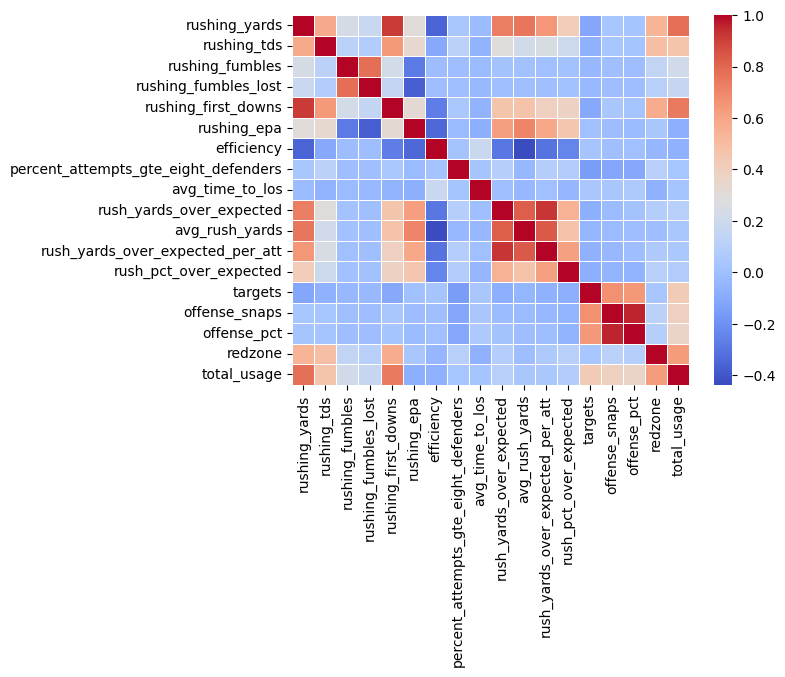

In [8]:
import seaborn as sns
import matplotlib as plt

correlation_matrix = weekly[rushing_cols].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()

In [11]:
engine = create_engine("postgresql+psycopg2://tbakely@localhost:5432/thefantasybot")

id_sql.to_sql('ids', engine, if_exists= 'replace')

140

In [2]:
import nfl_data_py as nfl

TypeError: import_ngs_data() missing 1 required positional argument: 'stat_type'

In [2]:
from analysis import NFLVerseData

In [8]:
weekly = NFLVerseData([2023]).get_weekly()
weekly2 = NFLVerseData([2022]).get_weekly()

2023 done.
Downcasting floats.
Downcasting floats.
2022 done.
Downcasting floats.
Downcasting floats.


In [7]:
weekly.head()

,player_id,player_name,player_display_name,position,position_group,recent_team,season,week,season_type,completions,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,00-0019596,T.Brady,Tom Brady,QB,QB,TB,2022,1,REG,18,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,10.38,10.38
1,00-0019596,T.Brady,Tom Brady,QB,QB,TB,2022,2,REG,18,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,9.40,9.40
2,00-0019596,T.Brady,Tom Brady,QB,QB,TB,2022,3,REG,31,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,14.74,14.74
3,00-0019596,T.Brady,Tom Brady,QB,QB,TB,2022,4,REG,39,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,25.40,25.40
4,00-0019596,T.Brady,Tom Brady,QB,QB,TB,2022,5,REG,35,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,19.74,19.74


In [9]:
set(weekly.columns) - set(weekly2.columns)

{'opponent_team'}